In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os, sys, re

from collections import Counter

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

## Load Data
Files to load: all (`os.listdir` with model specified) vs specific list

Note: `reference` might also contain non test files - filter out

In [5]:
def name_adapt(s:str, extra_patterns:list=[]):
    extra_patterns += ['finetuned', '.csv']
    for p in extra_patterns:
        s = s.replace(p,'')
    # replace adjacent '-' / '_' with only one
    return re.sub('[-_]{1,}','-',s)


In [7]:
dataset = "paco-cheese"
data_folder = f"../data/{dataset}"
gf_reference = "gpt2-fr-training_file_1024.csv"
model_patterns = ['rnn', 'gpt']
data_paths = {
    ("reference" if x == gf_reference else name_adapt(x,[dataset])):x for x in os.listdir(data_folder) if any([y in x for y in model_patterns])
}

In [8]:
gpt_ctx_nopivot = [x for x in data_paths.keys() if 'c0-8.csv' in x]
if len(gpt_ctx_nopivot) > 0:
    gpt_c08l = pd.read_csv(os.path.join(data_folder, data_paths.pop(gpt_ctx_nopivot[0])))
data_paths

{'reference': 'gpt2-fr-training_file_1024.csv',
 'gpt2-fr-c0-8-p': 'gpt2-fr-paco-cheese-finetuned-paco-cheese-paco-cheesec0-8-p.csv',
 'gpt2-fr-cs': 'gpt2-fr-paco-cheese-finetuned-paco-cheese-cs.csv',
 'gpt2-fr-c0-8': 'gpt2-fr-paco-cheese-finetuned-paco-cheese-c0-8.csv',
 'gpt2-fr-cf': 'gpt2-fr-paco-cheese-finetuned-paco-cheese-cf.csv'}

In [9]:
df = {}
for k,v in data_paths.items():
    tmp = pd.read_csv(os.path.join(data_folder,v))
    if 'model' in tmp.columns:
        # first way: only add the model pattern
        model_pat = [x for x in model_patterns if x in k][0] # _has_ one based on previous filter
        tmp.model = tmp.model.apply(lambda x: f'{model_pat}_{x}'if model_pat not in x else x)
        # second way: add a new column for the origin file
    else: # typically: reference
        tmp['model'] = k
    df[k] = tmp

res = pd.concat(df.values(), axis=0)

In [10]:
if 'reference' in res.model.unique():
    test_files = res[res.model != 'reference'].file.unique()
    res = res[res.file.isin(test_files)]

In [97]:
res.head()

,corpus,file,dyad,index,speaker,start,stop,text,theme,theme_role,...,context_2,context_3,context_4,context_5,context_6,context_7,context_ 000,context_<|endoftext|>000,context_<|endoftext|>100,sum_h
0,cheese,Cheese-AA_OR,AAOR,0,AA,4.54,4.83993,tu as,hetero selection,g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cheese,Cheese-AA_OR,AAOR,2,OR,6.62,7.00991,frog joke,Lecture frog joke OR,g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cheese,Cheese-AA_OR,AAOR,3,OR,7.42,10.86995,un jour un ingénieur traversait la rue quand u...,Lecture frog joke OR,g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cheese,Cheese-AA_OR,AAOR,4,OR,11.36,13.83519,si tu m'embrasses je me transforme en belle pr...,Lecture frog joke OR,g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
res.isna().sum(axis=0)

corpus                          0
file                            0
dyad                            0
index                           0
speaker                         0
start                           0
stop                            0
text                          135
theme                        1170
theme_role                   6600
theme_index                     0
has_theme                       0
h                           53424
normalised_h                    9
length                          0
tokens_h                        0
tokens                          0
xu_h                            9
model                           0
context_0                   26712
text_u                       3942
context_1                    3816
context_2                    3816
context_3                    3816
context_4                    3816
context_5                    3816
context_6                    3816
context_7                    3816
context_ 000                 3816
context_<|endo

In [17]:
length_by_file = res.groupby('file')['index'].max().to_dict()

In [11]:
models = res.model.unique()
models

array(['reference', 'gpt_context_0', 'gpt_context_1', 'gpt_context_2',
       'gpt_context_3', 'gpt_context_4', 'gpt_context_5', 'gpt_context_6',
       'gpt_context_7', 'gpt2-fr-cs', 'gpt2-fr-c0-8',
       'gpt2-fr-paco-cheese-finetuned-context_ 000—bs1',
       'gpt2-fr-paco-cheese-finetuned-context_ 000—bs8',
       'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1',
       'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs8',
       'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>100—bs1',
       'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>100—bs8'],
      dtype=object)

## Plots

### Checking consistency

In [18]:
reference_name = 'gpt2-fr-cs'#'reference'#'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'#'reference'

In [19]:
models = res.model.unique()
merge_cols = ['file', 'index', 'speaker', 'text']
int_cols = ['normalised_h', 'xu_h', 'length']
cols = merge_cols + int_cols
comparison_df = {}
if reference_name in models:
    ref = res[res.model == reference_name][cols]
    for model in models:
        c = pd.merge(left=ref, right=res[res.model == model][cols], left_on=merge_cols, right_on=merge_cols, suffixes=('_ref', '_mod'))
        print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
        comparison_df[model] = c
    

Correlation for model reference: normalised_h 0.6673651831329087 - xu_h 0.6623719447596959
Correlation for model gpt_context_0: normalised_h 0.9218613640170383 - xu_h 0.9154810116642156
Correlation for model gpt_context_1: normalised_h 0.7312724879520557 - xu_h 0.8125132467660579
Correlation for model gpt_context_2: normalised_h 0.7320149375667591 - xu_h 0.8138658962550032
Correlation for model gpt_context_3: normalised_h 0.7344219778797181 - xu_h 0.8164433233328324
Correlation for model gpt_context_4: normalised_h 0.7367584309922859 - xu_h 0.8178653153587825
Correlation for model gpt_context_5: normalised_h 0.7356180440391632 - xu_h 0.8161186268556464
Correlation for model gpt_context_6: normalised_h 0.7386849386588562 - xu_h 0.8181175192653307
Correlation for model gpt_context_7: normalised_h 0.7397822987827739 - xu_h 0.8192809971041249
Correlation for model gpt2-fr-cs: normalised_h 1.0 - xu_h 1.0
Correlation for model gpt2-fr-c0-8: normalised_h nan - xu_h nan
Correlation for model g

In [13]:
#comparison_name = 'gpt2-en-maptask-file-1024'
comparison_name = 'gpt2-fr-cs'

Correlation for model gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>100—bs8: normalised_h 0.9796668176369423 - xu_h 0.9559811897398244


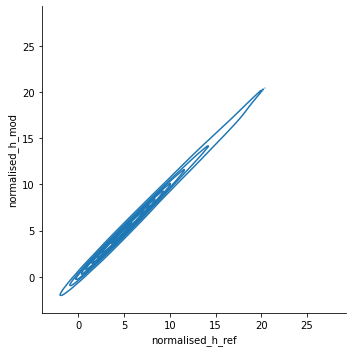

In [16]:
c = comparison_df[comparison_name]
c = c[c.length_ref == c.length_mod]
print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
sns.displot(data=c, x="normalised_h_ref", y="normalised_h_mod", kind="kde")

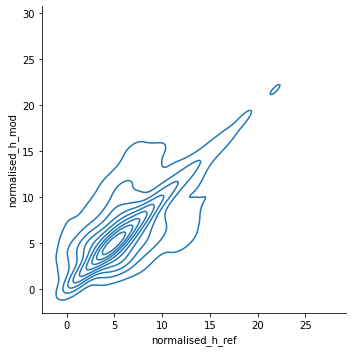

In [17]:
#sns.displot(data=comparison_df['gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'], x="normalised_h_ref", y="normalised_h_mod", kind="kde")
sns.displot(data=comparison_df[comparison_name], x="normalised_h_ref", y="normalised_h_mod", kind="kde")

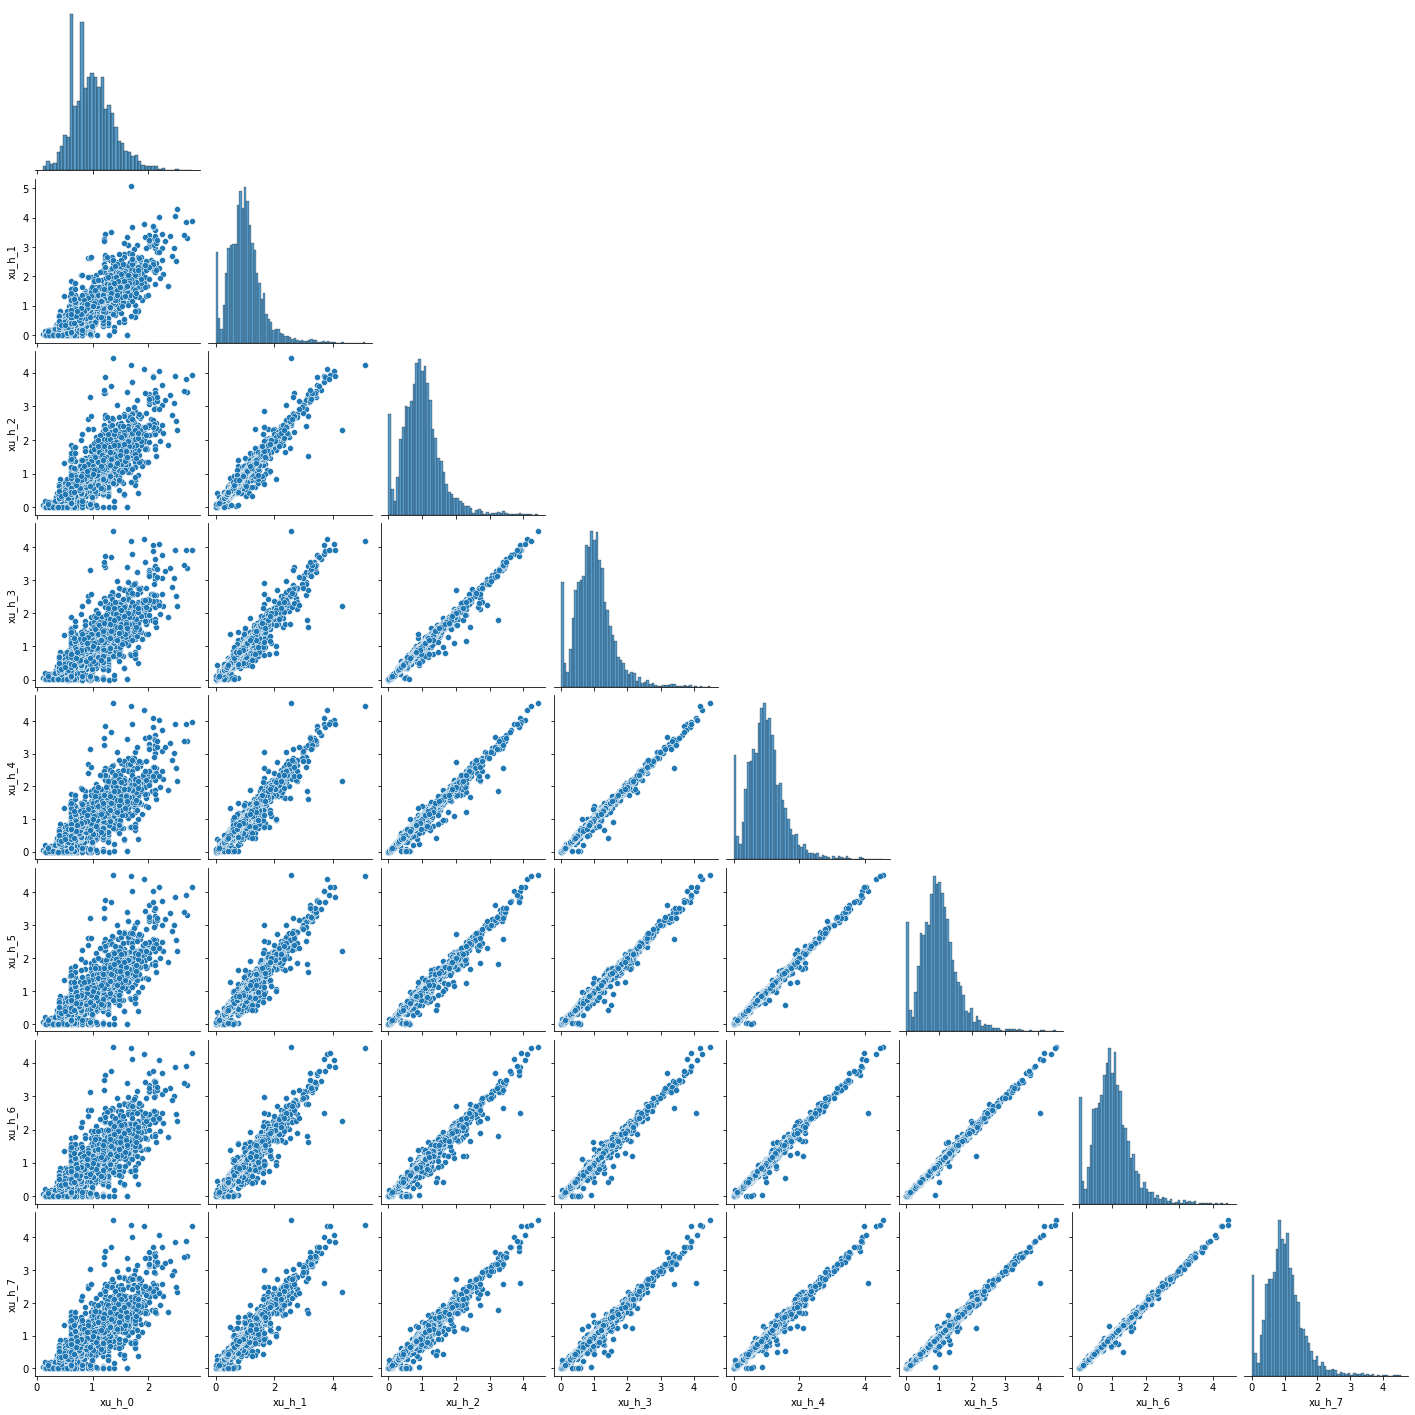

In [65]:
sns.pairplot(gpt_c08l, vars = [f'xu_h_{i}' for i in range(0,8)], corner=True)
plt.show()

### Generals

In [23]:
# keep for study
dialogs = res[res.model.isin(['reference', 'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'])]

In [24]:
sns.relplot(
    data=dialogs,
    x="index", y="normalised_h",
    hue="speaker", col='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

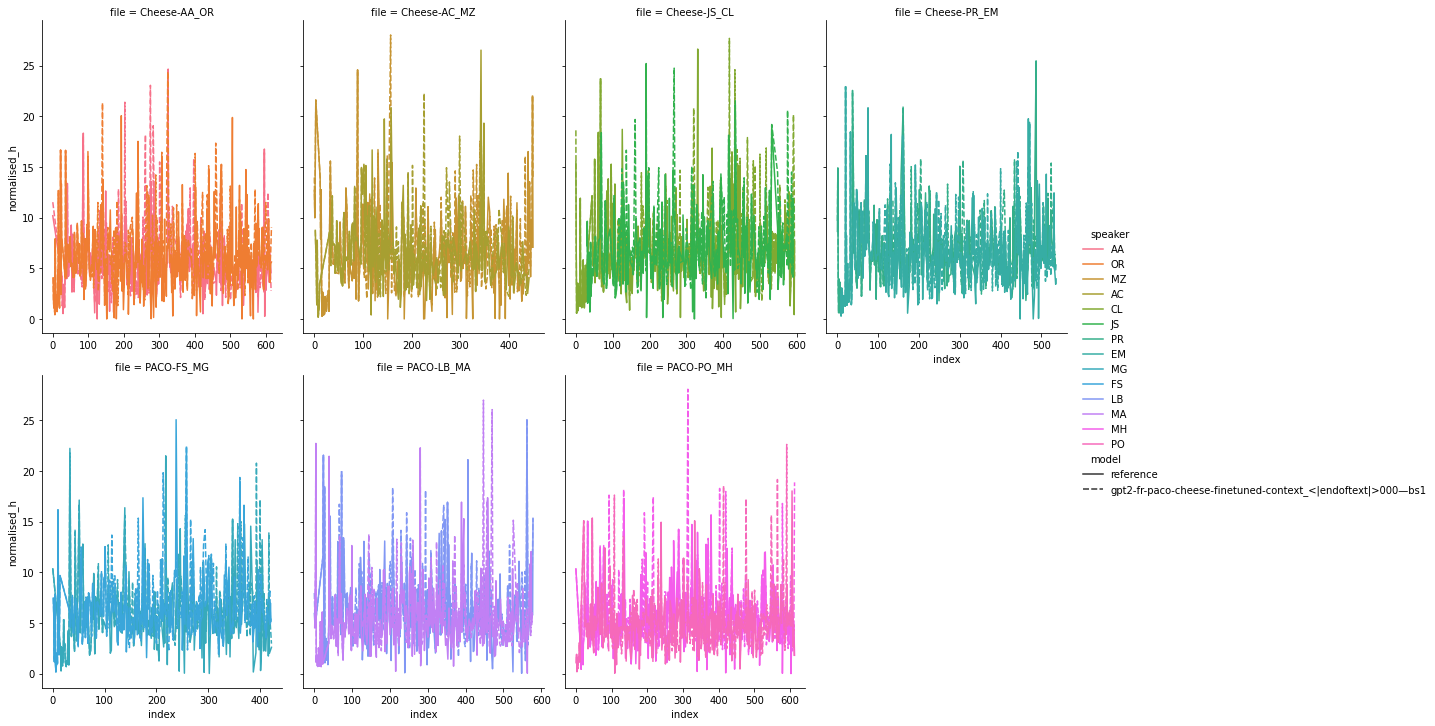

In [108]:
sns.relplot(
    data=dialogs,
    x="index", y="normalised_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

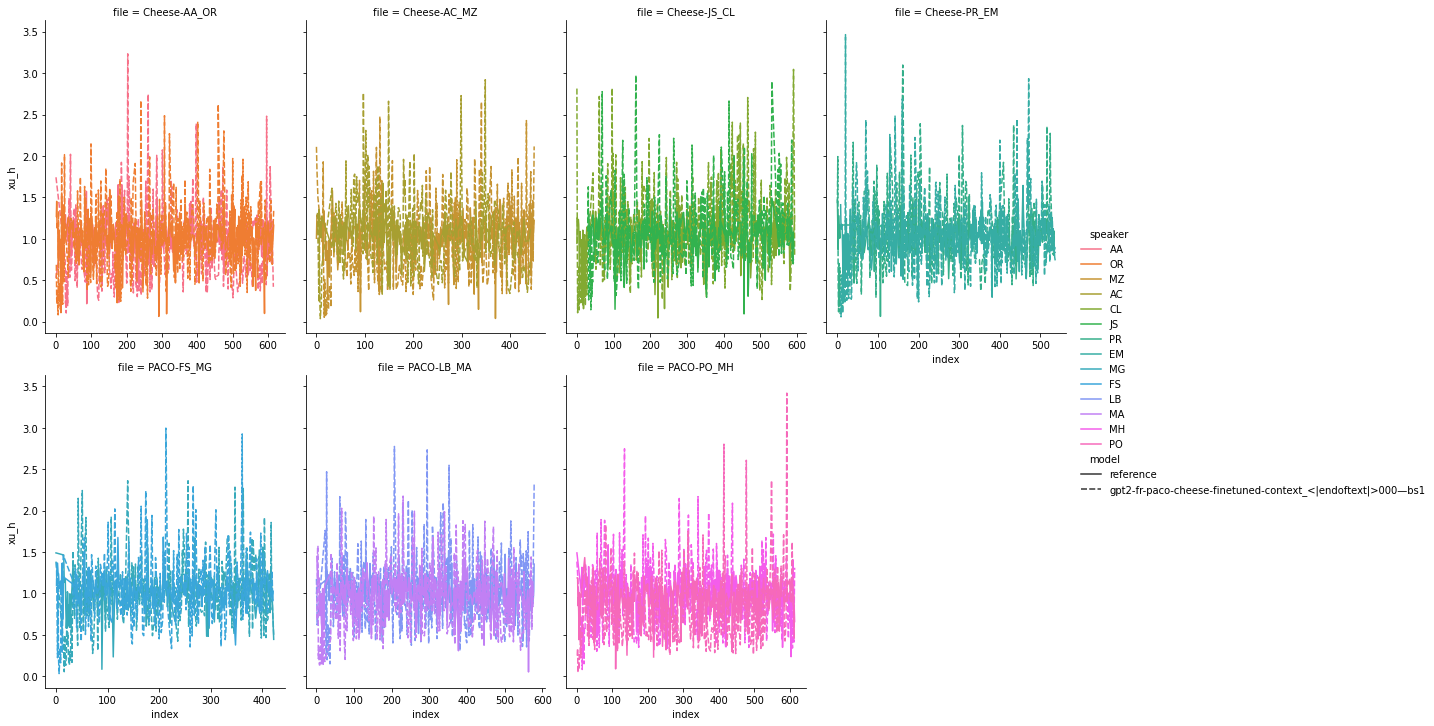

In [78]:
sns.relplot(
    data=dialogs,
    x="index", y="xu_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

### By episodes

Number of themes by file?

<AxesSubplot:ylabel='Density'>

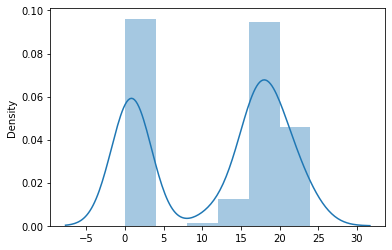

In [20]:
sns.distplot(dialogs.drop_duplicates(subset=['file','theme']).groupby('file').count())

In [109]:
# For the 2nd one: reindex => take the sign * max number
# Remove lines with extra transitions then for each one take the lines before / after and index and concat
# Note: issue with duplicated themes
not_transition = (dialogs.theme != 'transition').astype(int)
#dialogs = dialogs[dialogs.theme != 'transition']
dialogs['theme_index'] = (dialogs.theme != dialogs.theme.shift()).cumsum()
nb_in_ep = dialogs.groupby(['file', 'theme_index']).agg({'index': lambda x: range(len(x))}).explode('index')['index'].to_list()
inv_nb_in_ep = dialogs.groupby(['file', 'theme_index']).agg({'index': lambda x: range(-len(x),0)}).explode('index')['index'].to_list()
dialogs['count_after'] = nb_in_ep * not_transition
dialogs['count_before'] =  inv_nb_in_ep * not_transition

In [110]:
def compute_transitions_df(dialogs:pd.DataFrame, min_idx:int=10, max_idx:int=40):
    # TODO: add checks on columns
    # remove_transitions
    dialogs = dialogs[dialogs.theme != 'transition'].reset_index(drop=True)
    # get lines with 0
    new_themes = dialogs[dialogs.count_after == 0]
    new_themes['theme_index'] = range(new_themes.shape[0])

    final_df = []
    for idx, row in new_themes.iterrows():
        tmp = dialogs.iloc[max(0,idx-min_idx):min(dialogs.shape[0],idx+max_idx)]
        tmp['index'] = range(max(-min_idx,-idx), min(max_idx,dialogs.shape[0] - idx))
        # no need to check on file / model, done automatically
        tmp['ba'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else x.count_before, axis=1)
        tmp = tmp[tmp['index'] == tmp.ba]
        tmp['theme_index'] = row.theme_index
        # Add for plotting
        tmp['count_after'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else np.nan, axis=1)
        tmp['count_before'] = tmp.apply(lambda x: x.count_before if x['index'] <= 0 else np.nan, axis=1)
        # Add initiator / responder
        tmp['is_initiator'] = (tmp.speaker == row.speaker)
        # Add to df
        final_df.append(tmp)

    final_df = pd.concat(final_df, ignore_index=True)
    final_df['is_initiator'] = final_df.is_initiator.apply(lambda x: x * 'initiator' + (1 - x) * 'responder')
    return final_df

In [111]:
final_df = compute_transitions_df(dialogs, max_idx=10)
final_df.shape

(5229, 36)

In [112]:
target_col = "normalised_h"

Differenciating between initiators and responders 

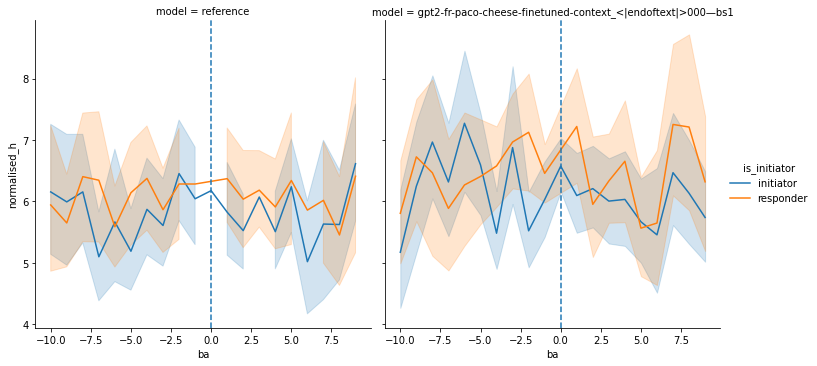

In [113]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')

Graph we want: apply `statsmodel` _before 0_ and _after 0_ and plot it on the same graph (with a scatterplot for the values)

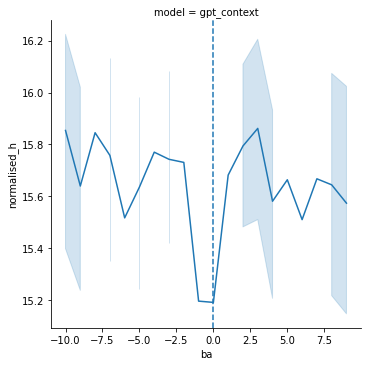

In [27]:
target_col = "normalised_h"
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model')
model_memory = {model:{} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        tmp = final_df[final_df.model == model].dropna(subset=[col])
        x = np.array([tmp['index'].min(), tmp['index'].max()])
        reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
        #print(model, col, reg_model.params) # .summary() for full summary of model
        g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], 'b')
        model_memory[model][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


In [114]:
target_col = "xu_h"

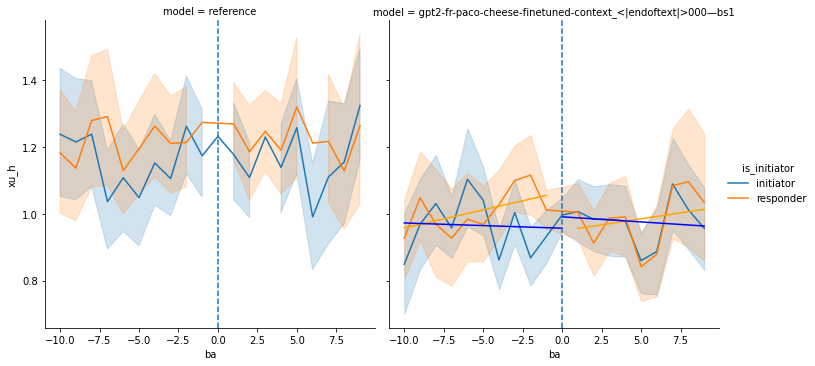

In [115]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
model_memory = {model:{spk:{} for spk in ['initiator','responder']} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        for spk, c in zip(['responder', 'initiator'], ['orange', 'b']):
            tmp = final_df[(final_df.model == model) & (final_df.is_initiator == spk)].dropna(subset=[col])
            x = np.array([tmp['index'].min(), tmp['index'].max()])
            reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
            #print(model, col, reg_model.params) # .summary() for full summary of model
            g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], c)
            model_memory[model][spk][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


Investigating a given model:
```python
for spk in ['initiator', 'responder']:
    print(f"\n-------------------{spk.upper()}------------------")
    print(model_memory['gpt_context'][spk]['count_after'].summary())
```

Data Exploration for one sentence

In [103]:
res[res.text == 'mh ouais si tu veux'][[col for col in res.columns if 'context_' not in col]]

,corpus,file,dyad,index,speaker,start,stop,text,theme,theme_role,...,has_theme,h,normalised_h,length,tokens_h,tokens,xu_h,model,text_u,sum_h
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,28.442576,4.063225,7,"[-11.516682624816895, -0.17777733504772186, -3...","['m', 'h', 'Ġou', 'ais', 'Ġsi', 'Ġtu', 'Ġveux']",0.864351,reference,NaN,NaN
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.212218,7,"[-11.058761596679688, -2.373636484146118, -3.6...",4.147299,0.646360,gpt_context_0,mh ouais si tu veux,29.485528
3817,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147302,7,"[-10.792609214782715, -0.26334744691848755, -4...",4.147299,0.822468,gpt_context_1,mh ouais si tu veux,29.031112
7633,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147304,7,"[-10.79261589050293, -0.2633468508720398, -4.2...",4.147299,0.842557,gpt_context_2,mh ouais si tu veux,29.031125
11449,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792576789855957, -0.263347864151001, -4.2...",4.147299,0.844409,gpt_context_3,mh ouais si tu veux,29.031081
15265,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792576789855957, -0.26334843039512634, -4...",4.147299,0.846863,gpt_context_4,mh ouais si tu veux,29.031081
19081,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147301,7,"[-10.792603492736816, -0.26334670186042786, -4...",4.147299,0.847680,gpt_context_5,mh ouais si tu veux,29.031104
22897,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147299,7,"[-10.79259204864502, -0.26334816217422485, -4....",4.147299,0.848037,gpt_context_6,mh ouais si tu veux,29.031096
26713,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147299,7,"[-10.79259204864502, -0.26334816217422485, -4....",4.147299,0.849066,gpt_context_7,mh ouais si tu veux,29.031096
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792593002319336, -0.2633475661277771, -4....",4.147297,0.851300,gpt2-fr-paco-cheese-finetuned-context_ 000—bs1,mh ouais si tu veux,29.031082


In [129]:
tmp = comparison_df['gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'].dropna()

In [130]:
tmp['normalised_h_diff'] = (tmp.normalised_h_ref - tmp.normalised_h_mod).abs()/tmp.normalised_h_ref

In [131]:
tmp.sort_values(by='normalised_h_diff', ascending=False).head(20)

,file,index,speaker,text,normalised_h_ref,xu_h_ref,length_ref,normalised_h_mod,xu_h_mod,length_mod,normalised_h_diff
3805,PACO-PO_MH,603,MH,ouais putain,0.000012,0.000002,1,3.075799,0.454410,4,255490.852987
842,Cheese-AC_MZ,225,MZ,ouais c'est des choses différentes quand même ...,0.000044,0.000006,1,4.490942,0.845567,13,103213.062627
2111,Cheese-PR_EM,448,EM,à la fin de la belle au bois dormant enfin de ...,0.000096,0.000013,1,5.653749,1.093170,16,59126.767365
1390,Cheese-JS_CL,322,JS,grave enfin non putain,0.000200,0.000026,1,10.151037,1.523746,5,50797.361249
152,Cheese-AA_OR,152,OR,là c'est loupé genre euh,0.000191,0.000025,1,6.948676,1.238965,9,36302.715022
998,Cheese-AC_MZ,381,MZ,c'est euh,0.000109,0.000014,1,3.498724,0.525184,5,32240.257536
533,Cheese-AA_OR,533,OR,il arrive à m'aligner euh,0.000237,0.000031,1,6.841631,1.156938,8,28828.139415
125,Cheese-AA_OR,125,AA,genre les j'ai vu mes deux résumés je les ai r...,0.000416,0.000055,1,5.373933,0.993172,21,12918.161182
565,Cheese-AA_OR,565,OR,moins que l'année dernière,0.000778,0.000147,2,4.009387,0.740427,6,5155.659811
2143,Cheese-PR_EM,480,EM,tu sais c'était en prévision d'aujourd'hui,0.004278,0.000812,2,6.045893,1.154089,12,1412.167760


In [136]:
file = 'PACO-PO_MH'
idx = 603

cond = (res.file == file) & (res['index'] >= idx-3) & (res['index'] <= idx+3) & (res.model.isin(['reference', 'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1']))

res[cond][[col for col in res.columns if 'context_' not in col]]

,corpus,file,dyad,index,speaker,start,stop,text,theme,theme_role,...,has_theme,h,normalised_h,length,tokens_h,tokens,xu_h,model,text_u,sum_h
13993,paco,PACO-PO_MH,POMH,600,MH,1097.08000,1098.08947,ah ouais oh putain,les partiels bloqués,g,...,True,133.489285,4.306106,31,"[-0.0072759222239255905, -1.0994895696640015, ...","[""'"", 'ai', 'Ġune', 'Ġcop', 'ine', 'Ġelle', 'Ġ...",1.037510,reference,NaN,NaN
13994,paco,PACO-PO_MH,POMH,601,PO,1100.04000,1101.57500,et sur euh sur euh internet quoi,les partiels bloqués,f,...,True,32.988854,4.712693,7,"[-3.8220934867858887, -0.0006459941505454481, ...","['Ġeu', 'h', 'Ġsur', 'Ġeu', 'h', 'Ġinternet', ...",1.002510,reference,NaN,NaN
13995,paco,PACO-PO_MH,POMH,602,MH,1101.14793,1101.35000,o,les partiels bloqués,g,...,True,42.897279,5.362160,8,"[-3.983919143676758, -0.0006343045388348401, -...","['Ġeu', 'h', 'Ġsur', 'Ġeu', 'h', 'Ġinternet', ...",1.126764,reference,NaN,NaN
13996,paco,PACO-PO_MH,POMH,603,MH,1101.74000,1102.72000,ouais putain,les partiels bloqués,g,...,True,0.000012,0.000012,1,[-1.2038735803798772e-05],['ain'],0.000002,reference,NaN,NaN
13997,paco,PACO-PO_MH,POMH,604,PO,1102.20198,1104.35000,donc en fait euh elle a pas eu de deuxième sem...,les partiels bloqués,f,...,True,18.947634,4.736908,4,"[-2.5894711017608643, -3.101306676864624, -9.5...","['Ġeu', 'Ġde', 'ĠdeuxiÃ¨me', 'Ġsemestre']",0.942283,reference,NaN,NaN
13998,paco,PACO-PO_MH,POMH,605,MH,1105.32034,1105.84000,ah ouais,les partiels bloqués,g,...,True,45.090226,4.099111,11,"[-4.7982361138565466e-05, -6.773531913757324, ...","['h', 'Ġelle', 'Ġa', 'Ġpas', 'Ġeu', 'Ġde', 'Ġd...",0.866476,reference,NaN,NaN
13999,paco,PACO-PO_MH,POMH,606,PO,1105.74034,1109.09176,donc certes elle est passée en deuxième année ...,les partiels bloqués,f,...,True,54.060188,18.020063,3,"[-21.375282287597656, -6.7890543937683105, -25...","['Ġlangues', 'ĠÃ©trangÃ¨res', 'ĠappliquÃ©es']",3.386719,reference,NaN,NaN
11434,paco,PACO-PO_MH,POMH,600,MH,1097.08000,1098.08947,ah ouais oh putain,les partiels bloqués,g,...,True,NaN,3.831290,7,"[-11.967547416687012, -3.511500120162964, -0.0...",3.83129,0.646225,gpt2-fr-paco-cheese-finetuned-context_<|endoft...,ah ouais oh putain,26.819030
11435,paco,PACO-PO_MH,POMH,601,PO,1100.04000,1101.57500,et sur euh sur euh internet quoi,les partiels bloqués,f,...,True,NaN,5.218586,9,"[-5.213949680328369, -9.057604789733887, -3.61...",5.218586,0.930486,gpt2-fr-paco-cheese-finetuned-context_<|endoft...,et sur euh sur euh internet quoi,46.967273
11436,paco,PACO-PO_MH,POMH,602,MH,1101.14793,1101.35000,o,les partiels bloqués,g,...,True,NaN,9.637651,1,[-9.637651443481445],9.637651,0.668415,gpt2-fr-paco-cheese-finetuned-context_<|endoft...,o,9.637651
